# Dynamics-based modeling

In [3]:
using DifferentialEquations, Plots, SymPy
include("essentials.jl")
include("in_silico_neuron_red.jl")

neuron_IV (generic function with 1 method)

## Integrate-and-fire (IF) models

### Lapicque's IF model

Defining equations

\begin{align*}
	\left\{\begin{array}{ll}
		\dot V(t) =  I(t)/C,&\quad\mbox{if } V(t)\leq V_{th}\\
		V(t) \leftarrow V_{reset}, &\quad\mbox{if } V(t)\geq V_{th}\\
	\end{array}\right.
\end{align*}

In [4]:
function IF(du,u,p,t)
    Iapp=p[1] # Amplitude of constant applied current
    It=p[2]
    
    V=u[1] # Variable
    
    du[1] = Iapp+It(t)
end
function spikeIF(u)  # spikes when spike(x) goes from negative to positive
    (u[1] - Vth)
end
function resetIF!(u) # reset function
    u[1] = Vr
end
function conditionIF(u,t,integrator) # event when event_f(u,t) == 0
    spikeIF(u)
end
function affectIF!(integrator) # when condition == 0 and upcrossing (from negative to positive)
    resetIF!(integrator.u)
end

affectIF! (generic function with 1 method)

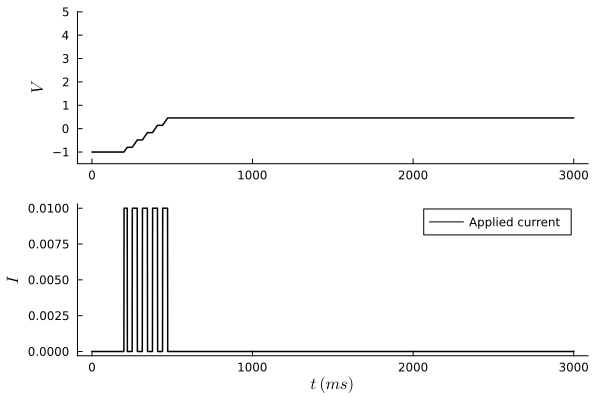

In [5]:
Tfinal=3000.0
tspan=(0.0,Tfinal)

# Definition of parameter values
Vth=1.; # Threshold voltage
Vr=-1.; # Reset voltage

# Input current
Iapp=0.
I1=0.01 # Amplitude of first pulse
ti1=200. # Starting time of first pulse
tf1=501 # Ending time of first pulse
I2=0.5 # Amplitude of first pulse
ti2=1000. # Starting time of first pulse
tf2=Tfinal+1 # Ending time of first pulse

#It(t) = I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2) + 0.1*Inoise(t)
It(t) = I1*pulse(t,ti1,tf1)*heaviside(sin(0.1*t))

# Initial conditions
x0=[Vr];

p=(Iapp,It)

cb   = ContinuousCallback(conditionIF,affectIF!,nothing)
prob = ODEProblem(IF,x0,tspan,p,callback=cb)
sol  = solve(prob,dtmax=1.0,dense=false);  # dense=false, avoids nonlinear interpolations between time steps when plotting (no impact on computation)

p1=plot(sol.t,sol[1,:],linewidth=1.5, linecolor="black", label="",ylims=(-1.5,5))
ylabel!(L"V")
p2=plot(sol.t,It.(sol.t).+Iapp,linewidth=1.5, linecolor="black", label="Applied current")
ylabel!(L"I")
xlabel!(L"t\ (ms)")

plot(p1,p2,layout=(2,1),grid=false)

#savefig(PP_QIF,"24-QIF.pdf")


<blockquote>
Test the response of the IF model for different pulse amplitude and duration. What is the behavior of the model in the subthreshold region?
</blockquote>

### Student response :

In the subthreshold region there is no decay of the neuron voltage. Therefore, the impulses will be integrated and kept to the same level for an indefinite amount of time. Or until enough inputs are given to reach the threshold and reset the voltage. This can make a very small input create a spike whereas a past large input did not.

### Leaky Integrate-and-fire (LIF) model 

Defining equations
\begin{align*}
	\left\{\begin{array}{ll}
		\dot V(t) =  \displaystyle \frac{-G_l(V-E_l) + I(t)}{C},&\quad\mbox{if } V(t)< V_{th}\\
		V(t) \leftarrow V_{reset}, &\quad\mbox{if } V(t)\geq V_{th}\\
	\end{array}\right.
\end{align*}

In [6]:
## LIF model
function LIF(du,u,p,t)
    Iapp=p[1] # Amplitude of constant applied current
    It=p[2]
    gl=p[3]
    El=p[4]
    
    V=u[1] # Variable

    du[1] = -gl*(V-El)+Iapp+It(t)
end
function spikeLIF(u)  # spikes when spike(x) goes from negative to positive
    (u[1] - Vth)
end
function resetLIF!(u) # reset function
    u[1] = Vr
end
function conditionLIF(u,t,integrator) # event when event_f(u,t) == 0
    spikeLIF(u)
end
function affectLIF!(integrator) # when condition == 0 and upcrossing (from negative to positive)
    resetLIF!(integrator.u)
end

affectLIF! (generic function with 1 method)

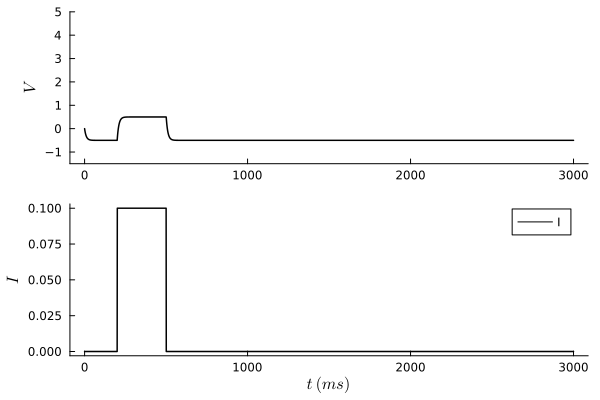

In [7]:
# Definition of parameter values
Vth=1.;
Vr=-1;
gl=0.1;
El=-0.5;

# Input current
Iapp=0.
I1=0.1 # Amplitude of first pulse
ti1=200. # Starting time of first pulse
tf1=501 # Ending time of first pulse
I2=0. # Amplitude of first pulse
ti2=1000. # Starting time of first pulse
tf2=Tfinal+1 # Ending time of first pulse

It(t) = I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2) # Play with noise intensity!
#It(t) = 1.9*I2*pulse(t,ti1,tf1)*heaviside(sin(0.8*t))

# Initial conditions
x0=[0.];

p=(Iapp,It,gl,El)

cb   = ContinuousCallback(conditionLIF,affectLIF!,nothing)
prob = ODEProblem(LIF,x0,tspan,p,callback=cb)
sol  = solve(prob,dtmax=1.0,dense=false);  # dense=false, avoids nonlinear interpolations between time steps when plotting (no impact on computation)

p1=plot(sol.t,sol[1,:],linewidth=1.5, linecolor="black", label="",ylims=(-1.5,5))
ylabel!(L"V")
p2=plot(sol.t,It.(sol.t).+Iapp,linewidth=1.5, linecolor="black", label="I")
ylabel!(L"I")
xlabel!(L"t\ (ms)")

plot(p1,p2,layout=(2,1),grid=false)
#xlims!(150,600)


<blockquote>
Test the response of the LIF model for different pulse amplitude and duration. What is the behavior of the model in the subthreshold region? What are the main differences between the IF and LIF models?
</blockquote>

### Student response :

Adding the leak term in the first equation changes drastically the behavior in the subthreshold region. Now the voltage decreases proportionally with the voltage across the neuron. The effect of this can be seen with the current intensity required to make the neuron spike as now a higher intensity is required to spike with the same threshold. 

Also, the increase of the potential difference is different with a leak term. The voltage first rises fast and slows down as it reaches equilibrium in the same way a classical capacitor would. Whereas the IF model increases linearly. 

Finally, adding the leak term allows for the exponential fading of the voltage that can be seen in the figure above when the current pulse ends. This makes the time difference and duration between inputs also important in the LIF compared to the IF where the neuron is a simple never fading integrator of the input.

## Phase plane models

## 1.1.1 Spike excitability and spiking
We start by only considering the transient sodium current and the delayed-rectifier potassium current. These are the current types originally measured and modeled by Hodgkin and Huxley. They constitute the basic building blocks of spike excitability and spiking in most neuron types. All other maximal conductances are set to zero. 

#### The following cell simulates the same model response to a pulse and then a step input of excitatory current. 

In [8]:
## Definition of maximal conductance values. 
Gl=2.0; # Leak current maximal conductance
GNa=100.; # Sodium current maximal conductance
GKd=65.; # Delayed-rectifier potassium current maximal conductance
GAf=0.; # Fast A-type potassium current maximal conductance
GAs=0.; # Slow A-type potassium current maximal conductance
GKCa=0.; # Calcium-activated potassium current maximal conductance
GCaL=0.; # L-type calcium current maximal conductance
GCaT=0.; # T-type calcium current maximal conductance
GH=0.; # H-current maximal conductance

## Initial conditions
V0= -50.; mKd0=mKdinf(V0); hCaT0=hCaTinf(V0); 
mCaL0=mCaLinf(Vs(mKd0)); mCaT0=mCaTinf(Vs(mKd0));
Ca0=(-α*GCaL*mCaL0*(V0-VCa))+(-β*GCaT*mCaT0*hCaT0*(V0-VCa))

x0 = [V0; mKd0; hCaT0; Ca0]

## Definition of simulation time.
Tfinal=1000.0
tspan=(0.0,Tfinal)

## Input current defition
# Constant current
Iapp=8

# Current pulses
I1=0. # Amplitude of first pulse 30 or 33
ti1=100 # Starting time of first pulse
tf1=100.4 # Ending time of first pulse
I2= 0 # Amplitude of second pulse 12 or 13
ti2=500 # Starting time of second pulse
tf2=1001 # Ending time of first pulse

It(t)=I1*pulse(t,ti1,tf1)+I2*pulse(t,ti2,tf2)

## Current-clamp experiment
# Parameter vector for simulations
p=(Iapp,It,GNa,GKd,GAf,GAs,GKCa,GCaL,GCaT,GH,Gl)

# Simulation
prob = ODEProblem(neuron_CC_red,x0,tspan,p) # Simulation without noise (ODE)
sol = solve(prob,dtmax=0.1);

# solve simulation for spiking Iapp values

Iapp_spike = 25
p_spike=(Iapp_spike,It,GNa,GKd,GAf,GAs,GKCa,GCaL,GCaT,GH,Gl)

prob_spike = ODEProblem(neuron_CC_red,x0,tspan,p_spike) # Simulation without noise (ODE)
sol_spike = solve(prob_spike,dtmax=0.1);

#Figure generation in the next (hidden cell)

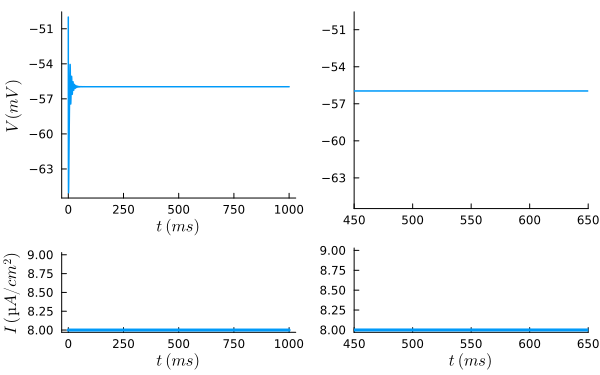

In [9]:
## Generation of figures 
# Voltage response
p1=plot(sol.t, sol[1,:],linewidth=1.5,legend=false)
ylabel!(L"V\ (mV)")
xlabel!(L"t\ (ms)")

p1zoom=plot(sol.t, sol[1,:],linewidth=1.5,legend=false,xlims=(450.,650.))

# Input current
t=range(0.0,Tfinal,length=10000)
p2=plot(t,Iapp .+I1*pulse.(t,ti1,tf1)+I2*pulse.(t,ti2,tf2),linewidth=3)
xlabel!(L"t\ (ms)")
ylabel!(L"I\ (µA/cm^2)")

p2zoom=plot(t,Iapp .+It.(t),linewidth=3,xlims=(450.,650.))
xlabel!(L"t\ (ms)")

l = @layout [
    [a{1.0*w,0.7*h}
    b{1.0*w,0.3*h}] [c{1.0*w,0.7*h}
                d{1.0*w,0.3*h}]
]

CC = plot(p1,p2,p1zoom,p2zoom,layout=l,legend=false,size=(600,375),grid=false)

#savefig(CC,"11-Currentclamp-spiking.pdf")

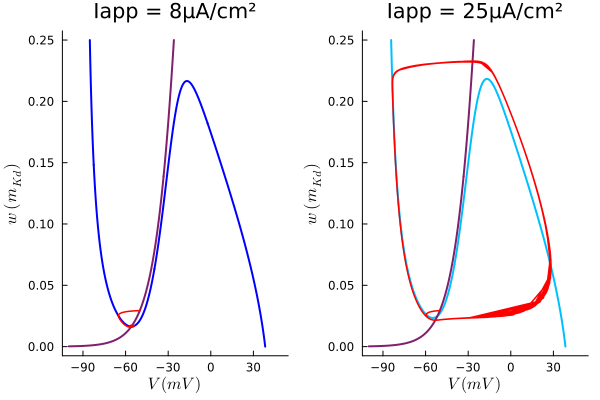

In [10]:
hCaT=hCaT0;
Ca=Ca0;
Vdot(V,mKd) = (-GNa*mNainf(V)*hNainf(Vs(mKd))*(V-VNa) +
                    # Potassium Currents
                    -GKd*mKd*(V-VK) -GAf*mAfinf(V)*hAfinf(Vs(mKd))*(V-VK) -GAs*mAsinf(Vs(mKd))*hAsinf(Vu(hCaT))*(V-VK) +
                    -GKCa*mKCainf(Ca)*(V-VK) +
                    # Calcium currents
                    -GCaL*mCaLinf(Vs(mKd))*(V-VCa) +
                    -GCaT*mCaTinf(Vs(mKd))*hCaT*(V-VCa) +
                    # Cation current
                    -GH*mHinf(Vu(hCaT))*(V-VH) +
                    # Passive currents
                    -Gl*(V-Vl) +
                    # Stimulation currents
                    +Iapp)

Vdot2(V,mKd) = (-GNa*mNainf(V)*hNainf(Vs(mKd))*(V-VNa) +
                    # Potassium Currents
                    -GKd*mKd*(V-VK) -GAf*mAfinf(V)*hAfinf(Vs(mKd))*(V-VK) -GAs*mAsinf(Vs(mKd))*hAsinf(Vu(hCaT))*(V-VK) +
                    -GKCa*mKCainf(Ca)*(V-VK) +
                    # Calcium currents
                    -GCaL*mCaLinf(Vs(mKd))*(V-VCa) +
                    -GCaT*mCaTinf(Vs(mKd))*hCaT*(V-VCa) +
                    # Cation current
                    -GH*mHinf(Vu(hCaT))*(V-VH) +
                    # Passive currents
                    -Gl*(V-Vl) +
                    # Stimulation currents
                    +Iapp_spike)

mKddot(V,mKd) = mKdinf(V)-mKd

Vvec = range(-100,50,length=1000);
mKdvec = range(-0.,0.25,length=1000);

p1 = contour(Vvec,mKdvec,Vdot,levels=[0],lc="blue",colorbar=false,linewidth=2)
contour!(Vvec,mKdvec,mKddot,levels=[0],linewidth=2)
#contour!(Vvec,mKdvec,Vdot2,levels=[0],lc="deepskyblue",colorbar=false,linewidth=2)
plot!(sol[1,:],sol[2,:],lc="red",linewidth=1.5,grid=false,xlabel=L"V\ (mV)",ylabel=L"w\ (m_{Kd})",label="", title="Iapp = 8µA/cm²")

p2 = contour(Vvec,mKdvec,Vdot2,levels=[0],lc="deepskyblue",colorbar=false,linewidth=2)
contour!(Vvec,mKdvec,mKddot,levels=[0],linewidth=2)
#contour!(Vvec,mKdvec,Vdot2,levels=[0],lc="deepskyblue",colorbar=false,linewidth=2)
plot!(sol_spike[1,:],sol_spike[2,:],lc="red",linewidth=1.5,grid=false,xlabel=L"V\ (mV)",ylabel=L"w\ (m_{Kd})",label="", title="Iapp = 25µA/cm²")

plot(p1, p2)

<blockquote>
Plot the phase portrait of the model for different values of input current corresponding to silent and spiking behaviors. Using the phase portrait, describe the dynamics of spiking.
</blockquote>

### Student response : 

The applied current translates vertically the blue nullcline corresponding to the V nullcline. When the nullcline moves it changes the fixed point to an unstable node through a saddle node bifurcation.

### Quadratic Integrate-and-Fire model

The quadratic Integrate-and-Fire (QIF) model writes
\begin{align*}
	\left\{\begin{array}{ll}
		\dot V(t) =  V(t)^2+I(t),&\quad\mbox{if } V(t)< V_{max}\\
		V(t) \leftarrow V_{reset}, &\quad\mbox{if } V(t)\geq V_{max}\\
	\end{array}\right.
\end{align*}

In [11]:
## QIF model
function QIF(du,u,p,t)
    Iapp=p[1] # Amplitude of constant applied current
    It=p[2]

    V=u[1] # Variable

    du[1] = V^2+Iapp+It(t)
end
function spikeQIF(u)  # spikes when spike(x) goes from negative to positive
    (u[1] - Vmax)
end
function resetQIF!(u) # reset function
    u[1] = Vr
end
function conditionQIF(u,t,integrator) # event when event_f(u,t) == 0
    spikeQIF(u)
end
function affectQIF!(integrator)# when condition == 0 and upcrossing (from negative to positive)
    resetQIF!(integrator.u)
end


affectQIF! (generic function with 1 method)

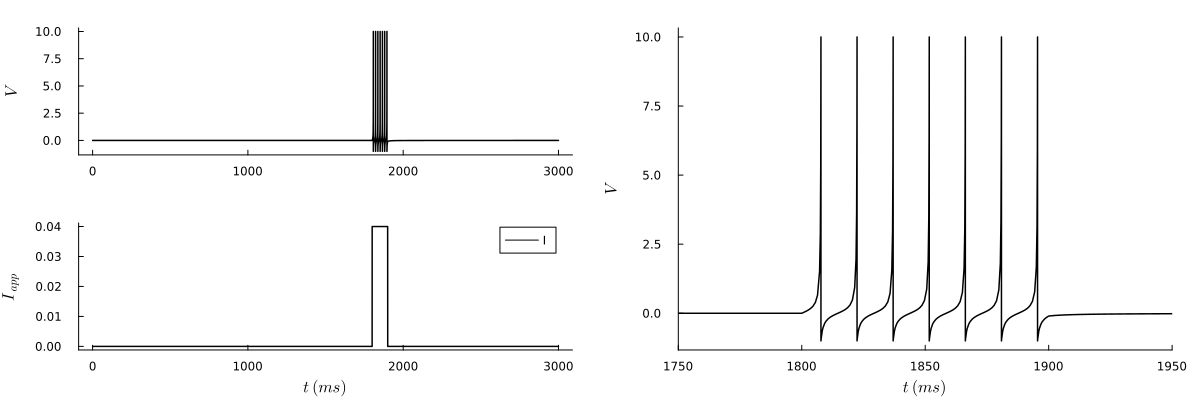

In [12]:
Tfinal=3000.0
tspan=(0.0,Tfinal)

# Definition of parameter values
Vmax=10.;
Vr=-1.;

# Input current
Iapp= 0
I1=0.04 # Amplitude of first pulse
ti1=1800. # Starting time of first pulse
tf1=1900 # Ending time of first pulse
I2=0. # Amplitude of first pulse
ti2=1000. # Starting time of first pulse
tf2=Tfinal+1 # Ending time of first pulse

It(t) = I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2)

# Initial conditions
x0=[0.];

p=(Iapp,It)

cb   = ContinuousCallback(conditionQIF,affectQIF!,nothing)
prob = ODEProblem(QIF,x0,tspan,p,callback=cb)
sol  = solve(prob,dtmax=1.0,dense=false);  # dense=false, avoids nonlinear interpolations between time steps when plotting (no impact on computation)

p1=plot(sol.t,sol[1,:],linewidth=1.5, linecolor="black",label="")
ylabel!(L"V")
p2=plot(sol.t,It.(sol.t).+Iapp,linewidth=1.5, linecolor="black", label="I")
ylabel!(L"I_{app}")
xlabel!(L"t\ (ms)")

p3 = plot(p1,p2,layout=(2,1))

p4 = p1=plot(sol.t,sol[1,:],linewidth=1.5, linecolor="black", label="",xlims=(1750,1950))
ylabel!(L"V")
xlabel!(L"t\ (ms)")

plot(p3,p4,size=(1200,400),margin=20px,grid=false)

#savefig(PP_QIF,"24-QIF.pdf")


<blockquote>
Explain how the QIF model is inspired from the phase portrait of the reduced-model above. What is the main difference between the QIF and the LIF? Test the behavior of the model for different pulse amplitude and duration.
</blockquote>

### Student response: 

The QIF model takes inspiration from the nullclines of the reduced model. The quadratic function models the shape of the V nullcline. When the value of V goes above 1 it diverges and is reset to a value within the basin of attraction ]-1 , 1[, when V_reset is reached.

Compared to the LIF model, the QIF model allows for a more gradual increase in spiking frequency. It is also closer to a real neuron as there is an actual voltage spike in the QIF before the reset of the voltage whereas the LIF resets directly the voltage with no spike.

### 2D Quadratic Integrate-and-Fire model

The 2D quadratic Integrate-and-Fire (QIF2D) model takes into account the dynamics of the slow variable $V_s(t)$. It writes

\begin{align*}
	\left\{\begin{array}{ll}
		\dot V(t) =  V(t)^2-V(t)+I(t)\\
        \dot V_s(t) =  (1/\tau_s)*(-V_s(t)+a*V(t))\\
		V(t) \leftarrow V_{reset}, V_s(t) \leftarrow V_{s,reset}, &\quad\mbox{if } V(t)\geq V_{max}
	\end{array}\right.
\end{align*}

In [13]:
function QIF2D(du,u,p,t)
    Iapp=p[1] # Amplitude of constant applied current
    It=p[2]
    taus=p[3]
    b=p[4]

    V=u[1] # Fast variable
    Vs=u[2] # Slow variable

    du[1] = V^2-Vs+Iapp+It(t)
    du[2] = 1/taus*(-Vs+a*V)
end
function spikeQIF2D(u)  # spikes when spike(x) goes from negative to positive
    (u[1] - Vmax)
end
function resetQIF2D!(u) # reset function
    u[1] = Vr
    u[2] = Vsr
end
function conditionQIF2D(u,t,integrator) # event when event_f(u,t) == 0
    spikeQIF2D(u)
end
function affectQIF2D!(integrator) # when condition == 0 and upcrossing (from negative to positive)
    resetQIF2D!(integrator.u)
end
function noise_QIF2D(du,u,p,t)
    du[1] = 0.2
end

noise_QIF2D (generic function with 1 method)

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


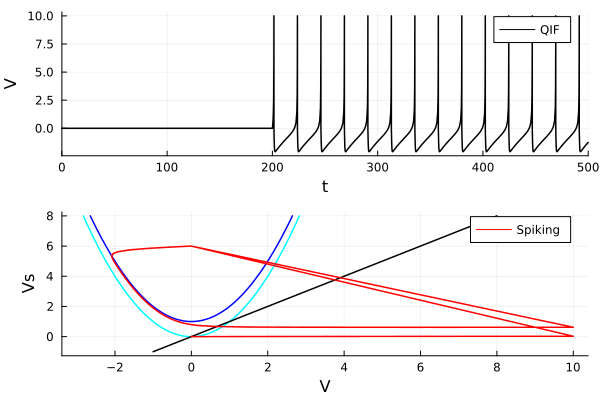

In [14]:
# Definition of simulation time.
Tfinal = 500. 
tspan=(0.,Tfinal)

# Definition of parameter values
taus=10.;
Vmax=10.;
Vr=0.;
Vsr=6.;

# Input current
Iapp=0.
I1=1 # Amplitude of first pulse
ti1=200. # Starting time of first pulse
tf1=501 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=800 # Starting time of second pulse
tf2=1001 # Ending time of first pulse

It(t) = I1*pulse(t,ti1,tf1) +I2*pulse(t,ti2,tf2)

# Initial conditions
x0=[0.,0.];

a = 0.1
p=(Iapp,It,taus,a)

cb   = ContinuousCallback(conditionQIF2D,affectQIF2D!,nothing)
prob = ODEProblem(QIF2D,x0,tspan,p,callback=cb)
#prob = SDEProblem(IZH,noise_IZH,x0,tspan,p,callback=cb)
sol  = solve(prob,dtmax=1.0,dense=false);  # dense=false, avoids nonlinear interpolations between time steps when plotting (no impact on computation)

## Phase portrait
## Definition of V, Vs vectors
V = -3:0.01:10 # Range for V
Vss = -1:0.01:8 # Range for Vs

## Definition of nullclines functions
# The V-nullcline corresponds to the points (V*,Vs*) for which dV/dt=0.
# The Vs-nullcline corresponds to the points (V*,Vs*) for which dVs/dt=0.
V_QIF(V, Vss) = (V)^2-Vss # V-nullcline function of QIF model
V_QIFstep(V, Vss) = (V)^2-Vss+I1 # V-nullcline function of QIF model
Vs_QIF(V, Vss) = (-Vss+V)/taus # Vs-nullcline function

## Generation of figures 
#p51=contour(V,Vs,V_FHN,levels=[0],linewidth=1.5,linecolor="cyan",colorbar=false) # V-nullcline (in cyan)
p51=contour(V,Vss,V_QIF,levels=[0],linewidth=1.5,linecolor="blue",colorbar=false) # V-nullcline (in blue)
xlabel!("V")
ylabel!("Vs")

p61=plot(sol,vars=(0,1),linewidth=1.5, linecolor="black", label="QIF")
ylabel!("V")

p62=contour(V,Vss,V_QIF,levels=[0],linewidth=1.5,linecolor="cyan",colorbar=false) # V-nullcline (in blue)
contour!(V,Vss,V_QIFstep,levels=[0],linewidth=1.5,linecolor="blue",colorbar=false) # V-nullcline (in blue)
contour!(V,Vss,Vs_QIF,levels=[0],linewidth=1.5,linecolor="black",colorbar=false) # mKd-nullcline (in black)
plot!(sol[1,:],sol[2,:],linewidth=1.5,linecolor="red", label="Spiking") # Trajectory from simulation
xlabel!("V")
ylabel!("Vs")

PP_QIF = plot(p61,p62,layout=(2,1))

#savefig(PP_QIF,"24-QIF.pdf")


<blockquote>
Test the behavior of the model for different pulse amplitude and duration. How does the phase portrait of the QIF2D relates to the phase portrait of the reduced model above. What are the main similarities and the main differences?
</blockquote>

### Student Response : 

The phase portrait of the QIF2D looks like a simplification of the reduced model at the biffurcation point. The N shaped V nullcline is replaced by a parabola with the quadratic function. The w nullcline is simplified by a linear function. 

The QIF2D phase portrait yields spiking with a bifurcation in the sae way the reduced model does. The V nullcline is vertically translated with I_app and creates a bifurcation. However, the shape of the spikes is very different. With the QIF2D model the spikes have a very angular shape that is not present in natural neurons.

## 1.1.3 Burst excitability and bursting
Voltage-gated calcium channels are another type of ion channels that have been highlighted early in the physiological literature. Voltage-gated calcium channels are similar to sodium channels, i.e. they carry an inward current, but their dynamics are at least an order of magnitude slower. <br>
Voltage-gated calcium channels also serv as a source of calcium entry into the cell that can subsequently activate calcium-activated potassium channels, forming an inward-outward pair reminiscent of the one created by transient sodium and delayed-rectifier potassium channels.

#### The following cell simulates model response to two pulses of different strengths when non-inactivating voltage-gated calcium channels and calcium-activated potassium channels are added to the sodium and delayed-rectifier spiking currents. 

In [15]:
## Definition of maximal conductance values. 
Gl=2.0; # Leak current maximal conductance
GNa=100.; # Sodium current maximal conductance
GKd=65.; # Delayed-rectifier potassium current maximal conductance
GAf=0.; # Fast A-type potassium current maximal conductance
GAs=0.; # Slow A-type potassium current maximal conductance
GKCa=8.; # Calcium-activated potassium current maximal conductance
GCaL=1.5; # L-type calcium current maximal conductance
GCaT=0.; # T-type calcium current maximal conductance
GH=0.; # H-current maximal conductance

## Initial conditions
V0= -60.; mKd0=mKdinf(V0); hCaT0=hCaTinf(V0); 
mCaL0=mCaLinf(Vs(mKd0)); mCaT0=mCaTinf(Vs(mKd0));
Ca0=(-α*GCaL*mCaL0*(V0-VCa))+(-β*GCaT*mCaT0*hCaT0*(V0-VCa))

x0 = [V0; mKd0; hCaT0; Ca0]

## Definition of simulation time.
Tfinal=2000.0
tspan=(0.0,Tfinal)

## Input current defition
# Constant current
Iapp= -60

# Current pulses
I1=0. # Amplitude of first pulse
ti1=500 # Starting time of first pulse
tf1=510 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=1200 # Starting time of second pulse
tf2=1210 # Ending time of first pulse

It(t)=I1*pulse(t,ti1,tf1)+I2*pulse(t,ti2,tf2)

## Current-clamp experiment
# Parameter vector for simulations
p=(Iapp,It,GNa,GKd,GAf,GAs,GKCa,GCaL,GCaT,GH,Gl)

# Simulation
prob = ODEProblem(neuron_CC_red,x0,tspan,p) # Simulation without noise (ODE)
sol = solve(prob,dtmax=0.1);

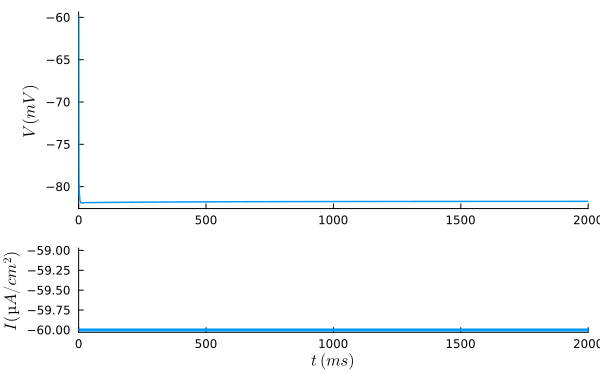

In [16]:
## Generation of figures 
# Voltage response
p1=plot(sol.t, sol[1,:],linewidth=1.5,legend=false)
ylabel!(L"V\ (mV)")

# Input current
t=range(0.0,Tfinal,length=1000)
p2=plot(t,Iapp .+I1*pulse.(t,ti1,tf1)+I2*pulse.(t,ti2,tf2),linewidth=3)
xlabel!(L"t\ (ms)")
ylabel!(L"I (µA/cm^2)")

l = @layout [
    a{1.0*w,0.7*h}
    b{1.0*w,0.3*h}
]

CC = plot(p1,p2,layout=l,legend=false,size=(600,375),grid=false)
xlims!(0,Tfinal)

#savefig(CC,"11-Currentclamp-burstExc.pdf")

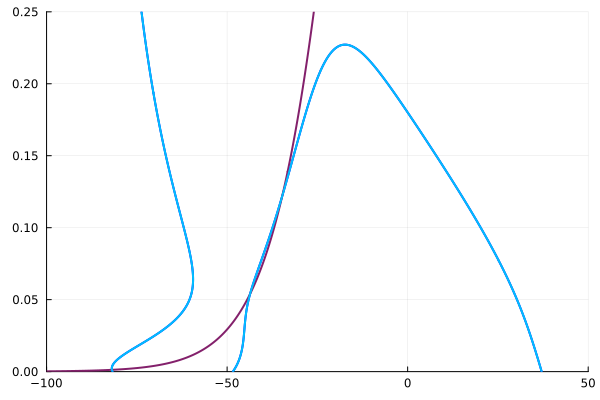

In [17]:
hCaT=hCaT0;
Ca=Ca0;
Vdot(V,mKd) = (-GNa*mNainf(V)*hNainf(Vs(mKd))*(V-VNa) +
                    # Potassium Currents
                    -GKd*mKd*(V-VK) -GAf*mAfinf(V)*hAfinf(Vs(mKd))*(V-VK) -GAs*mAsinf(Vs(mKd))*hAsinf(Vu(hCaT))*(V-VK) +
                    -GKCa*mKCainf(Ca)*(V-VK) +
                    # Calcium currents
                    -GCaL*mCaLinf(Vs(mKd))*(V-VCa) +
                    -GCaT*mCaTinf(Vs(mKd))*hCaT*(V-VCa) +
                    # Cation current
                    -GH*mHinf(Vu(hCaT))*(V-VH) +
                    # Passive currents
                    -Gl*(V-Vl) +
                    # Stimulation currents
                    +Iapp)

Vdot2(V,mKd) = (-GNa*mNainf(V)*hNainf(Vs(mKd))*(V-VNa) +
                    # Potassium Currents
                    -GKd*mKd*(V-VK) -GAf*mAfinf(V)*hAfinf(Vs(mKd))*(V-VK) -GAs*mAsinf(Vs(mKd))*hAsinf(Vu(hCaT))*(V-VK) +
                    -GKCa*mKCainf(Ca)*(V-VK) +
                    # Calcium currents
                    -GCaL*mCaLinf(Vs(mKd))*(V-VCa) +
                    -GCaT*mCaTinf(Vs(mKd))*hCaT*(V-VCa) +
                    # Cation current
                    -GH*mHinf(Vu(hCaT))*(V-VH) +
                    # Passive currents
                    -Gl*(V-Vl) +
                    # Stimulation currents
                    +Iapp+I2)

mKddot(V,mKd) = mKdinf(V)-mKd

Vvec = range(-100,50,length=1000);
mKdvec = range(-0.,0.25,length=1000);

Vnull1 = contour(Vvec,mKdvec,Vdot,levels=[0],lc="blue",colorbar=false,linewidth=2)
contour!(Vvec,mKdvec,mKddot,levels=[0],linewidth=2)
contour!(Vvec,mKdvec,Vdot2,levels=[0],lc="deepskyblue",colorbar=false,linewidth=2)
#plot!(sol[1,:],sol[2,:],lc="red",linewidth=1.5,grid=false,xlabel=L"V\ (mV)",ylabel=L"w\ (m_{Kd})",label="")

<blockquote>
Using the following cell and tuning the applied currents I2 and I3, plot 2 qualitatively different phase portraits as well as the degenerate situation that makes the frontier between both.   
</blockquote>

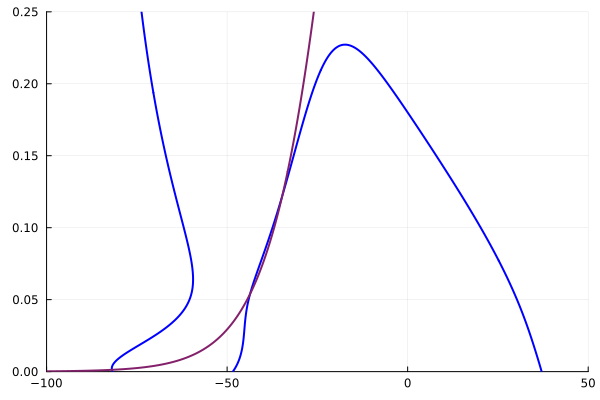

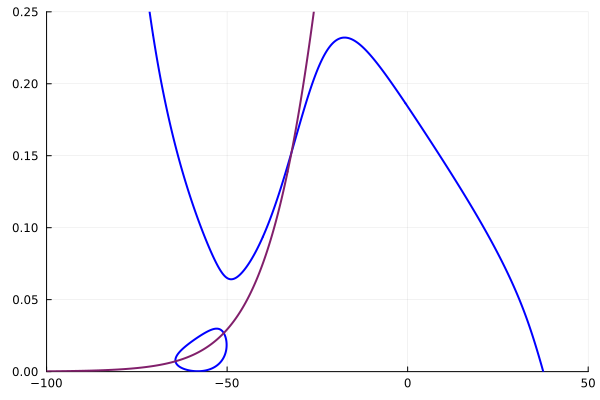

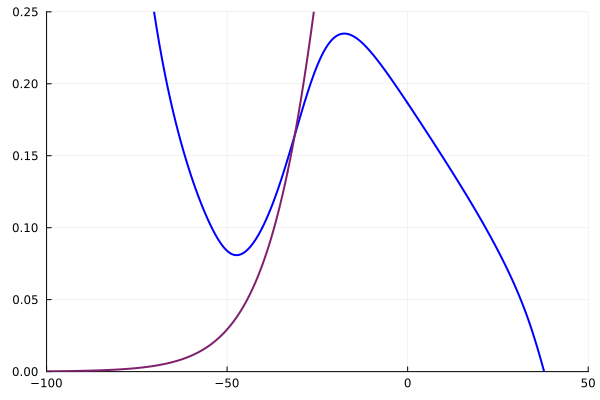

In [18]:
I2=45;
I3=70.;
hCaT=hCaT0;
Ca=Ca0;
Vdot(V,mKd) = (-GNa*mNainf(V)*hNainf(Vs(mKd))*(V-VNa) +
                    # Potassium Currents
                    -GKd*mKd*(V-VK) -GAf*mAfinf(V)*hAfinf(Vs(mKd))*(V-VK) -GAs*mAsinf(Vs(mKd))*hAsinf(Vu(hCaT))*(V-VK) +
                    -GKCa*mKCainf(Ca)*(V-VK) +
                    # Calcium currents
                    -GCaL*mCaLinf(Vs(mKd))*(V-VCa) +
                    -GCaT*mCaTinf(Vs(mKd))*hCaT*(V-VCa) +
                    # Cation current
                    -GH*mHinf(Vu(hCaT))*(V-VH) +
                    # Passive currents
                    -Gl*(V-Vl) +
                    # Stimulation currents
                    +Iapp)

Vdot2(V,mKd) = (-GNa*mNainf(V)*hNainf(Vs(mKd))*(V-VNa) +
                    # Potassium Currents
                    -GKd*mKd*(V-VK) -GAf*mAfinf(V)*hAfinf(Vs(mKd))*(V-VK) -GAs*mAsinf(Vs(mKd))*hAsinf(Vu(hCaT))*(V-VK) +
                    -GKCa*mKCainf(Ca)*(V-VK) +
                    # Calcium currents
                    -GCaL*mCaLinf(Vs(mKd))*(V-VCa) +
                    -GCaT*mCaTinf(Vs(mKd))*hCaT*(V-VCa) +
                    # Cation current
                    -GH*mHinf(Vu(hCaT))*(V-VH) +
                    # Passive currents
                    -Gl*(V-Vl) +
                    # Stimulation currents
                    +Iapp+I2)

Vdot3(V,mKd) = (-GNa*mNainf(V)*hNainf(Vs(mKd))*(V-VNa) +
                    # Potassium Currents
                    -GKd*mKd*(V-VK) -GAf*mAfinf(V)*hAfinf(Vs(mKd))*(V-VK) -GAs*mAsinf(Vs(mKd))*hAsinf(Vu(hCaT))*(V-VK) +
                    -GKCa*mKCainf(Ca)*(V-VK) +
                    # Calcium currents
                    -GCaL*mCaLinf(Vs(mKd))*(V-VCa) +
                    -GCaT*mCaTinf(Vs(mKd))*hCaT*(V-VCa) +
                    # Cation current
                    -GH*mHinf(Vu(hCaT))*(V-VH) +
                    # Passive currents
                    -Gl*(V-Vl) +
                    # Stimulation currents
                    +Iapp+I3)

mKddot(V,mKd) = mKdinf(V)-mKd

Vvec = range(-100,50,length=1000);
mKdvec = range(-0.,0.25,length=1000);

Vnull1 = contour(Vvec,mKdvec,Vdot,levels=[0],lc="blue",colorbar=false,linewidth=2)
contour!(Vvec,mKdvec,mKddot,levels=[0],linewidth=2)
#contour!(Vvec,mKdvec,Vdot2,levels=[0],lc="deepskyblue",colorbar=false,linewidth=2)
display(Vnull1)

Vnull2 = contour(Vvec,mKdvec,Vdot2,levels=[0],lc="blue",colorbar=false,linewidth=2)
contour!(Vvec,mKdvec,mKddot,levels=[0],linewidth=2)
#contour!(Vvec,mKdvec,Vdot2,levels=[0],liiic="deepskyblue",colorbar=false,linewidth=2)
display(Vnull2)

Vnull3 = contour(Vvec,mKdvec,Vdot3,levels=[0],lc="blue",colorbar=false,linewidth=2)
contour!(Vvec,mKdvec,mKddot,levels=[0],linewidth=2)
#contour!(Vvec,mKdvec,Vdot2,levels=[0],lc="deepskyblue",colorbar=false,linewidth=2)
display(Vnull3)
#contour(Vnull1,Vnull2,Vnull3,layout=(3,1))

### Transcritical Integrate-and-Fire model

The phase portrait of bursting shows that transitions to bursting is rulled by a transcritical bifurcation, leading to the creation of the transcitical Integrate-and-Fire (MQIF) model. The equation ruling $\dot V(t)$ is an unfolding of the normal form of the transcritical  bifurcation. It writes

\begin{align*}
	\left\{\begin{array}{ll}
		\dot V(t) =  V(t)^2+b*V(t)*V_s(t)-V_s(t)^2-V_u(t)+I(t)\\
        \dot V_s(t) =  (1/\tau_s)*(-V_s(t)+a*V(t)+w_0)\\
        \dot V_u(t) = (1/\tau_u)*(-V_u(t))\\
		V(t) \leftarrow V_{reset}, V_s(t) \leftarrow V_{s,reset}, V_u(t) \leftarrow V_u(t) + V_{u,reset}&\quad if  V(t)\geq V_{max}
	\end{array}\right.
\end{align*}

In [19]:
# MQIF
function MQIF(du,u,p,t)
    Iapp=p[1] # Amplitude of constant applied current
    It=p[2]
    taus=p[3]
    tauu=p[4]
    b=p[5]
    w0=p[6]

    V=u[1] # Fast variable
    Vs=u[2] # Slow variable
    Vu=u[3]

    du[1] = V^2+b*V*Vs-Vs^2-Vu+Iapp+It(t)
    du[2] = 1/taus*(-Vs+a*V+w0)
    du[3] = 1/tauu*(-Vu)
end
function spikeMQIF(u)  # spikes when spike(x) goes from negative to positive
    (u[1] - Vmax)
end
function resetMQIF!(u) # reset function
    u[1] = Vr
    u[2] = Vsr
    u[3] = u[3] + Vur
end
function conditionMQIF(u,t,integrator) # event when event_f(u,t) == 0
    spikeMQIF(u)
end
function affectMQIF!(integrator) # when condition == 0 and upcrossing (from negative to positive)
    resetMQIF!(integrator.u)
end
function noise_MQIF(du,u,p,t)
    du[1] = 0.2
end

noise_MQIF (generic function with 1 method)

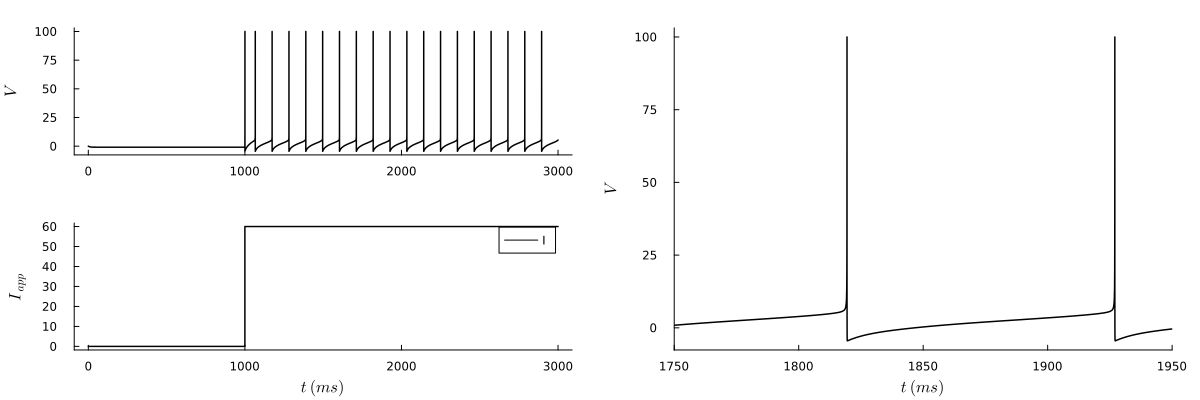

In [123]:
# Definition of simulation time.
Tfinal = 3000. 
tspan=(0.,Tfinal)

# Definition of parameter values
taus=10.;
tauu=100.;
a=0.1;
b=-3;
Vmax=100.;
Vr=15.;
Vsr=15.;
Vur=40.;

w0=3;

# Input current
Iapp=0
I1=60. # Amplitude of first pulse
ti1=1000. # Starting time of first pulse
tf1=3001 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=8000 # Starting time of second pulse
tf2=1001 # Ending time of first pulse

It(t) = I1*pulse(t,ti1,tf1)

# Initial conditions
x0=[0.,0.,0.];

p_pos=(Iapp,It,taus,tauu,b,w0)
p_neg=(Iapp,It,taus,tauu,b,-w0)

cb   = ContinuousCallback(conditionMQIF,affectMQIF!,nothing)
prob_pos = ODEProblem(MQIF,x0,tspan,p_pos,callback=cb)
sol_pos  = solve(prob_pos,dtmax=1.0,dense=false);  # dense=false, avoids nonlinear interpolations between time steps when plotting (no impact on computation)

prob_neg = ODEProblem(MQIF,x0,tspan,p_neg,callback=cb)
sol_neg  = solve(prob_neg,dtmax=1.0,dense=false);  # dense=false, avoids nonlinear interpolations between time steps when plotting (no impact on computation)

p1=plot(sol_pos.t,sol_pos[1,:],linewidth=1.5, linecolor="black",label="")
ylabel!(L"V")
p2=plot(sol_pos.t,It.(sol_pos.t).+Iapp,linewidth=1.5, linecolor="black", label="I")
ylabel!(L"I_{app}")
xlabel!(L"t\ (ms)")

p3 = plot(p1,p2,layout=(2,1))

p4 = p1=plot(sol_pos.t,sol_pos[1,:],linewidth=1.5, linecolor="black", label="",xlims=(1750,1950))
ylabel!(L"V")
xlabel!(L"t\ (ms)")

plot(p3,p4,size=(1200,400),margin=20px,grid=false)

#savefig(PP_QIF,"24-QIF.pdf")


<blockquote>
Test the response of the MQIF model for different pulse amplitude and duration, as well as for different values of w0 ranging from -5 to 5. Describe the behavior of the model for the different values of w0. To explain the different berhaviors, plot the phase portrait $V-V_s$ of the model for any chosen fixed value of $V_u$ for a positive and a negative value of $w_0$. 
</blockquote>

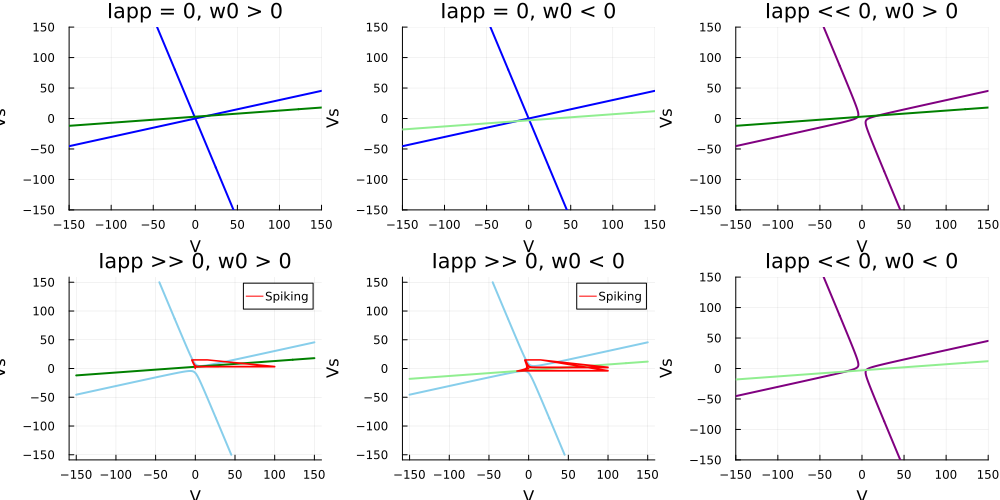

In [124]:
fixed_Vu = 0 

Vdot(V, Vs) = V*V + b * V * Vs - Vs * Vs - fixed_Vu + Iapp
Vsdot(V, Vs)= (1/taus) * (-Vs + a * V + w0)

Vsdot2(V, Vs)= (1/taus) * (-Vs + a * V - w0)
Vdot2(V, Vs) = V*V + b * V * Vs - Vs * Vs - fixed_Vu + Iapp + I1

Vdot3(V, Vs) = V*V + b * V * Vs - Vs * Vs - fixed_Vu + Iapp - I1

V_vec = range(-150,150,length=1000);
Vs_vec = range(-150,150,length=1000);

p1 = contour(V_vec,Vs_vec, Vdot, levels=[0],lc="blue",colorbar=false,linewidth=2) # Iapp = 0 => non spiking
contour!(V_vec,Vs_vec,Vsdot,levels=[0],lc="green",colorbar=false,linewidth=2)     # w0   > 0 => no burst
title!("Iapp = 0, w0 > 0")

xlabel!("V")
ylabel!("Vs")

p2 = contour(V_vec,Vs_vec, Vdot2, levels=[0],lc="skyblue",colorbar=false,linewidth=2) # Iapp >>  0 => spiking
contour!(V_vec,Vs_vec,Vsdot,levels=[0],lc="green",colorbar=false,linewidth=2)     # w0   > 0 => no burst
plot!(sol_pos[1,:],sol_pos[2,:],linewidth=1.5,linecolor="red", label="Spiking") # Trajectory from simulation

title!("Iapp >> 0, w0 > 0")
xlabel!("V")
ylabel!("Vs")

p3 = contour(V_vec,Vs_vec, Vdot, levels=[0],lc="blue",colorbar=false,linewidth=2) # Iapp = 0 => non spiking
contour!(V_vec,Vs_vec,Vsdot2,levels=[0],lc="lightgreen",colorbar=false,linewidth=2)  # w0   < 0 => can burst
title!("Iapp = 0, w0 < 0")
xlabel!("V")
ylabel!("Vs")

p4 = contour(V_vec,Vs_vec, Vdot2, levels=[0],lc="skyblue",colorbar=false,linewidth=2) # Iapp >> 0 => spiking
contour!(V_vec,Vs_vec,Vsdot2,levels=[0],lc="lightgreen",colorbar=false,linewidth=2)  # w0   < 0 => can burst
plot!(sol_neg[1,:],sol_neg[2,:],linewidth=1.5,linecolor="red", label="Spiking") # Trajectory from simulation

xlabel!("V")
ylabel!("Vs")
title!("Iapp >> 0, w0 < 0")

p5 = contour(V_vec,Vs_vec, Vdot3, levels=[0],lc="purple",colorbar=false,linewidth=2) # Iapp << 0 => non spiking
contour!(V_vec,Vs_vec,Vsdot,levels=[0],lc="green",colorbar=false,linewidth=2)  # w0   > 0 => no burst
xlabel!("V")
ylabel!("Vs")
title!("Iapp << 0, w0 > 0")

p6 = contour(V_vec,Vs_vec, Vdot3, levels=[0],lc="purple",colorbar=false,linewidth=2) # Iapp << 0 => non spiking
contour!(V_vec,Vs_vec,Vsdot2,levels=[0],lc="lightgreen",colorbar=false,linewidth=2)  # w0   < 0 => can burst
xlabel!("V")
ylabel!("Vs")
title!("Iapp << 0, w0 < 0")

plot(p1, p3, p5 ,p2, p4, p6, layout = (2, 3),size=(1000,500))

### Student response:

In the phase portraits above dark blue nullclines represent the V nullcline with no stimulus, light blue is with a positive current stimulus, and purple is a negative stimulus. In these phase portraits we can see two different types of bifurcation from changing the Iapp parameter. The first bifurcation can be seen when the stimulus is positive where the nullclines split horizontally. The second takes place when the stimulus is negative and the nullclines split vertically. 

Spiking only occurs when stimulus is positive and positive enough to not cross the Vs nullcline and create a saddle node bifurcation. This bifurcation crates the ability to spike. However, two different behaviors can be observed depending on which part of the V nullcline is closer to the Vs nullcline. If the Vs nullcline is closer to the upper nullcline curve spiking will occur without bursting and and its frequency will increase as V_dot and and V_s are further apart. This is because the effect of the ghost stable node will be reduced. On the other hand, bursting will take place if the Vs nullcline is closer to the bottom curve of the V nullcline.

<blockquote>
Test the response of the model for different pusle amplitude with $w_0=0$. What kind of excitability type does the model exhibit for this value of $w_0$. Try to explain this behavior using phase portraits. 
</blockquote>